In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import math
import torch._dynamo
torch._dynamo.config.suppress_errors = True
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

In [2]:
# Define the KANLinear class
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=10,
        spline_order=4,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.ReLU,
        grid_eps=0.01,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(A, B).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(2, 0, 1)  # (out_features, in_features, grid_size + spline_order)

        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        x = x.to(self.grid.device)  # Move x to the same device as grid
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
    
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(1, 0, 2)  # (batch, in, out)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=0.5, regularize_entropy=0.5):
        """
        Compute the regularization loss.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 24981 samples in 0.001s...
[t-SNE] Computed neighbors for 24981 samples in 2.539s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24981
[t-SNE] Computed conditional probabilities for sample 2000 / 24981
[t-SNE] Computed conditional probabilities for sample 3000 / 24981
[t-SNE] Computed conditional probabilities for sample 4000 / 24981
[t-SNE] Computed conditional probabilities for sample 5000 / 24981
[t-SNE] Computed conditional probabilities for sample 6000 / 24981
[t-SNE] Computed conditional probabilities for sample 7000 / 24981
[t-SNE] Computed conditional probabilities for sample 8000 / 24981
[t-SNE] Computed conditional probabilities for sample 9000 / 24981
[t-SNE] Computed conditional probabilities for sample 10000 / 24981
[t-SNE] Computed conditional probabilities for sample 11000 / 24981
[t-SNE] Computed conditional probabilities for sample 12000 / 24981
[t-SNE] Computed conditional probabilities for sam

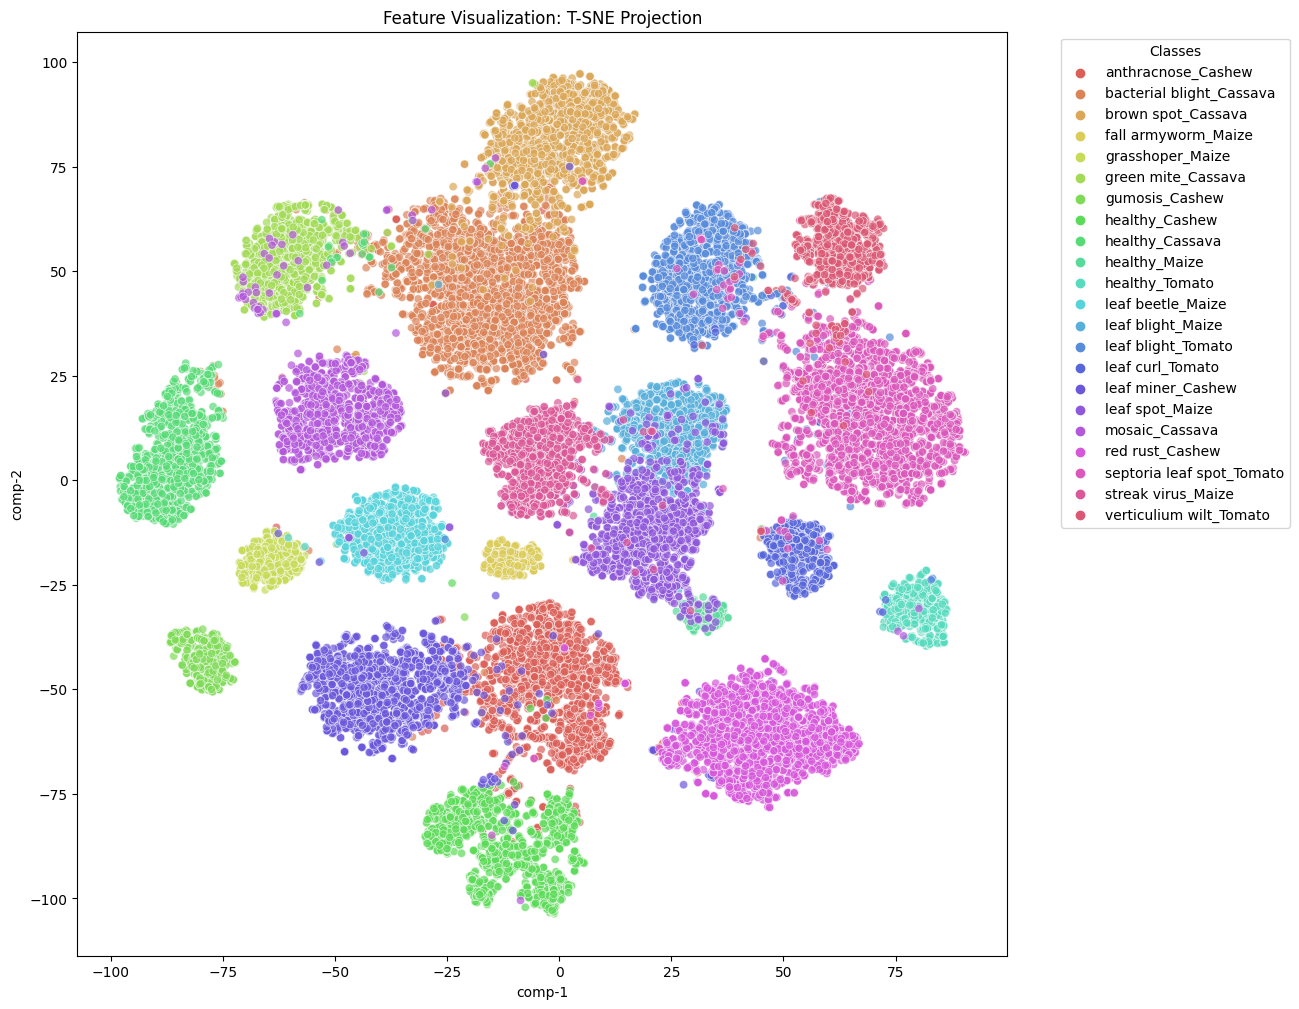

In [9]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from torchvision import datasets, transforms

model = models.resnet18(pretrained=False)
model.fc = KANLinear(in_features=model.fc.in_features, out_features=22)

model_path = "/kaggle/input/resnet18withkan9393/pytorch/default/1/resnet18withkan9393.pth"
model.load_state_dict(torch.load(model_path))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define dataset path and transformations
data_path = "/kaggle/input/pest-data/Testing_Data"
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust based on your model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_path, transform=data_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False)

# Extract class labels from the test folder
class_labels = dataset.classes

# Extract features using the model
features, labels = [], []
with torch.no_grad():
    for images, lbls in data_loader:
        images = images.cuda()  # Move to GPU if available
        lbls = lbls.cuda()
        outputs = model(images)
        features.append(outputs.cpu().numpy())  # Move to CPU and convert to numpy
        labels.append(lbls.cpu().numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Perform t-SNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(features)

# Prepare the data for visualization
df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

# Map numeric labels to class names
df["class"] = df["y"].map(lambda x: class_labels[x])

# Plot t-SNE results
plt.figure(figsize=(12, 12))  # Adjust the size of the plot
sns.scatterplot(x="comp-1", y="comp-2", hue="class",
                palette=sns.color_palette("hls", len(class_labels)),
                data=df, alpha=0.7).set(title="Feature Visualization: T-SNE Projection")
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title="Classes")  # Place legend outside the plot
plt.show()
